In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Ellipse, Circle
from astropy.io import ascii, fits
from astropy.table import Table
#from astropy.modeling import fitting, FittableModel, Fittable2DModel, Fittable1DModel, Parameter, custom_model
from astropy import wcs
from lmfit import minimize, Minimizer, report_fit, Model, Parameters
import lmfit
#import pandas as pd
from ipywidgets import FloatProgress
from IPython.display import display
from MUSE_Models import MUSE_3D_OIII, MUSE_3D_residual, PNextractor
import sep
from photutils import CircularAperture

%config InlineBackend.figure_format = 'retina'

In [15]:
#lnl_cube = fits.open("FCC255_data/FCC255_lnl_cube-005.fits")
#Gandalf_fit = fits.open("FCC255_data/FCC255_GandALF_fit-003.fits")
Gandalf_fit_emission = fits.open("FCC255_data/FCC255_GandALF_fit_emission-002.fits")
#ppxf_fit = fits.open("FCC255_data/FCC255_pPXF_fit-004.fits")

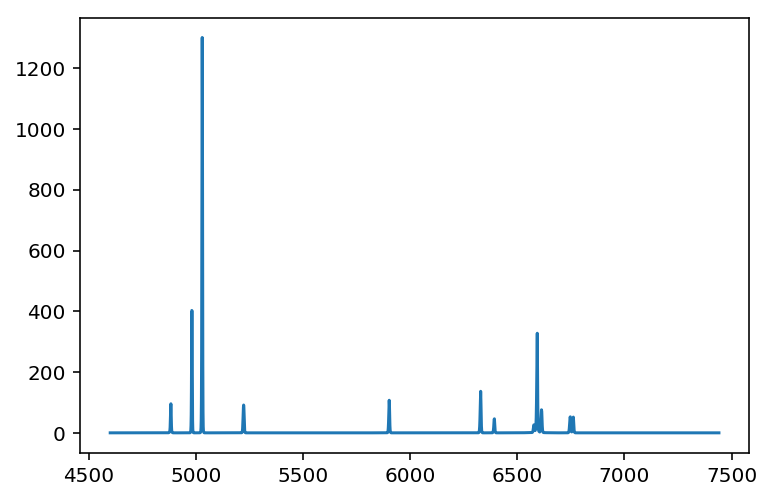

In [17]:
Gandalf_fit_emission = fits.open("FCC255_data/FCC255_GandALF_fit_emission-002.fits")
G_emission_cube = np.array(Gandalf_fit_emission[0].data).reshape(y_data, x_data, len(full_wavelength))
PNe_0 = PNextractor(206, 174, 11, G_emission_cube, wave=full_wavelength, dim=2)

plt.plot(full_wavelength, np.sum(PNe_0,0))

In [36]:
Gandalf_stellar = Gandalf_fit[0].data - Gandalf_fit_emission[0].data
emission_cube = lnl_cube[0].data - Gandalf_stellar

In [40]:
hdu = fits.PrimaryHDU(emission_cube)
hdu.writeto("FCC255_data/FCC255_emission_cube.fits")

In [2]:
# Open Fits file and assign to raw_data
hdulist = fits.open("FCC255_data/FCC255_emission_cube.fits")
raw_data = hdulist[0].data
hdr = hdulist[0].header

full_wavelength = np.load("exported_data/FCC255/wavelength.npy")
# wavelength[382] = 4940.58678
# wavelength[542] = 5090.374537
wavelength = full_wavelength[382:543]


y_data = 442 # hdr["NAXIS2"]
x_data = 449 # hdr["NAXIS1"]

coordinates = [(n,m) for n in range(x_data) for m in range(y_data)]

x_fit = np.array([item[0] for item in coordinates])
y_fit = np.array([item[1] for item in coordinates])

oo = np.loadtxt('FCC255_data/FCC255_xy_ima_yngoodspaxels.txt', skiprows=1)
fit_these = oo[:,3]

raw_data_list = raw_data[:,382:543]

raw_data_list_fitted = np.squeeze(np.where(fit_these == 1))

raw_data_list_for_fit = raw_data_list[raw_data_list_fitted]

# 1D fit function

In [3]:
def Gaussian_1D_res(params, x, data, error, spec_num):
    Amp = params["Amp"]
    mean = params["mean"]
    FWHM = params["FWHM"]
    Gauss_bkg = params["Gauss_bkg"]
    Gauss_grad = params["Gauss_grad"]
     
    Gauss_std = FWHM / 2.35482
    model = ((Gauss_bkg + Gauss_grad * x) + Amp * np.exp(- 0.5 * (x - mean)** 2 / Gauss_std**2.) +
             (Amp/3.) * np.exp(- 0.5 * (x - (mean - 47.9399))** 2 / Gauss_std**2.))
    
    list_of_rN[spec_num] = np.std(data - model)
    list_of_residuals[spec_num] = data - model
    
    return (data - model) / error


params = Parameters()
params.add("Amp",value=70., min=0.001)
params.add("mean", value=5030., min=5000., max=5080.)
params.add("FWHM", value=2.81, vary=False) # LSF
params.add("Gauss_bkg", value=0.001, min=-500., max=500.)
params.add("Gauss_grad", value=0.001)

list_of_std = np.array([np.abs(np.std(spec)) for spec in raw_data_list])
input_errors = [np.repeat(list_of_std[i], len(wavelength)) for i in np.arange(0,len(list_of_std))]

list_of_rN = np.zeros(len(raw_data_list))
list_of_residuals = np.zeros((len(raw_data_list),len(wavelength)))
list_of_residuals_from_fitter = np.zeros((len(raw_data_list),len(wavelength)))
best_fit_A = np.zeros((len(raw_data_list),2))
best_fit_mean = np.zeros((len(raw_data_list),2))


In [4]:
for spec_n in raw_data_list_fitted:
    results = minimize(Gaussian_1D_res, params, args=(wavelength, raw_data_list[spec_n], input_errors[spec_n], spec_n), nan_policy="propagate")
    best_fit_A[spec_n] = [results.params["Amp"], results.params["Amp"].stderr]
    best_fit_mean[spec_n] = [results.params["mean"], results.params["mean"].stderr]
    list_of_residuals_from_fitter[spec_n] = results.residual

In [9]:
gauss_A = [A[0] for A in best_fit_A]
A_err = [A[1] for A in best_fit_A]

A_rN = np.array([A / rN for A,rN in zip(gauss_A, list_of_rN)])
A_rN_shape = A_rN.reshape(y_data,x_data)

Gauss_F = np.array(gauss_A) * np.sqrt(2*np.pi) * 1.19
Gauss_F_shape = Gauss_F.reshape(y_data, x_data)

C:\Users\Thomas Spriggs\Miniconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.


In [11]:
np.save("exported_data/FCC255/A_rN_cen", A_rN)
np.save("exported_data/FCC255/gauss_A_cen", gauss_A)
np.save("exported_data/FCC255/gauss_A_err_cen", A_err)
np.save("exported_data/FCC255/gauss_F_cen", Gauss_F)
np.save("exported_data/FCC255/list_of_resids_min", list_of_residuals)
np.save("exported_data/FCC255/list_of_resids_min_obj", list_of_residuals_from_fitter)
np.save("exported_data/FCC255/rN", list_of_rN)

In [3]:
A_rN = np.load("exported_data/FCC255/A_rN_cen.npy")
gauss_A = np.load("exported_data/FCC255/gauss_A_cen.npy")
Gauss_F = np.load("exported_data/FCC255/gauss_F_cen.npy")

gauss_A_shape = gauss_A.reshape(y_data, x_data)
A_rN_shape = A_rN.reshape(y_data,x_data)
Gauss_F_shape = Gauss_F.reshape(y_data, x_data)

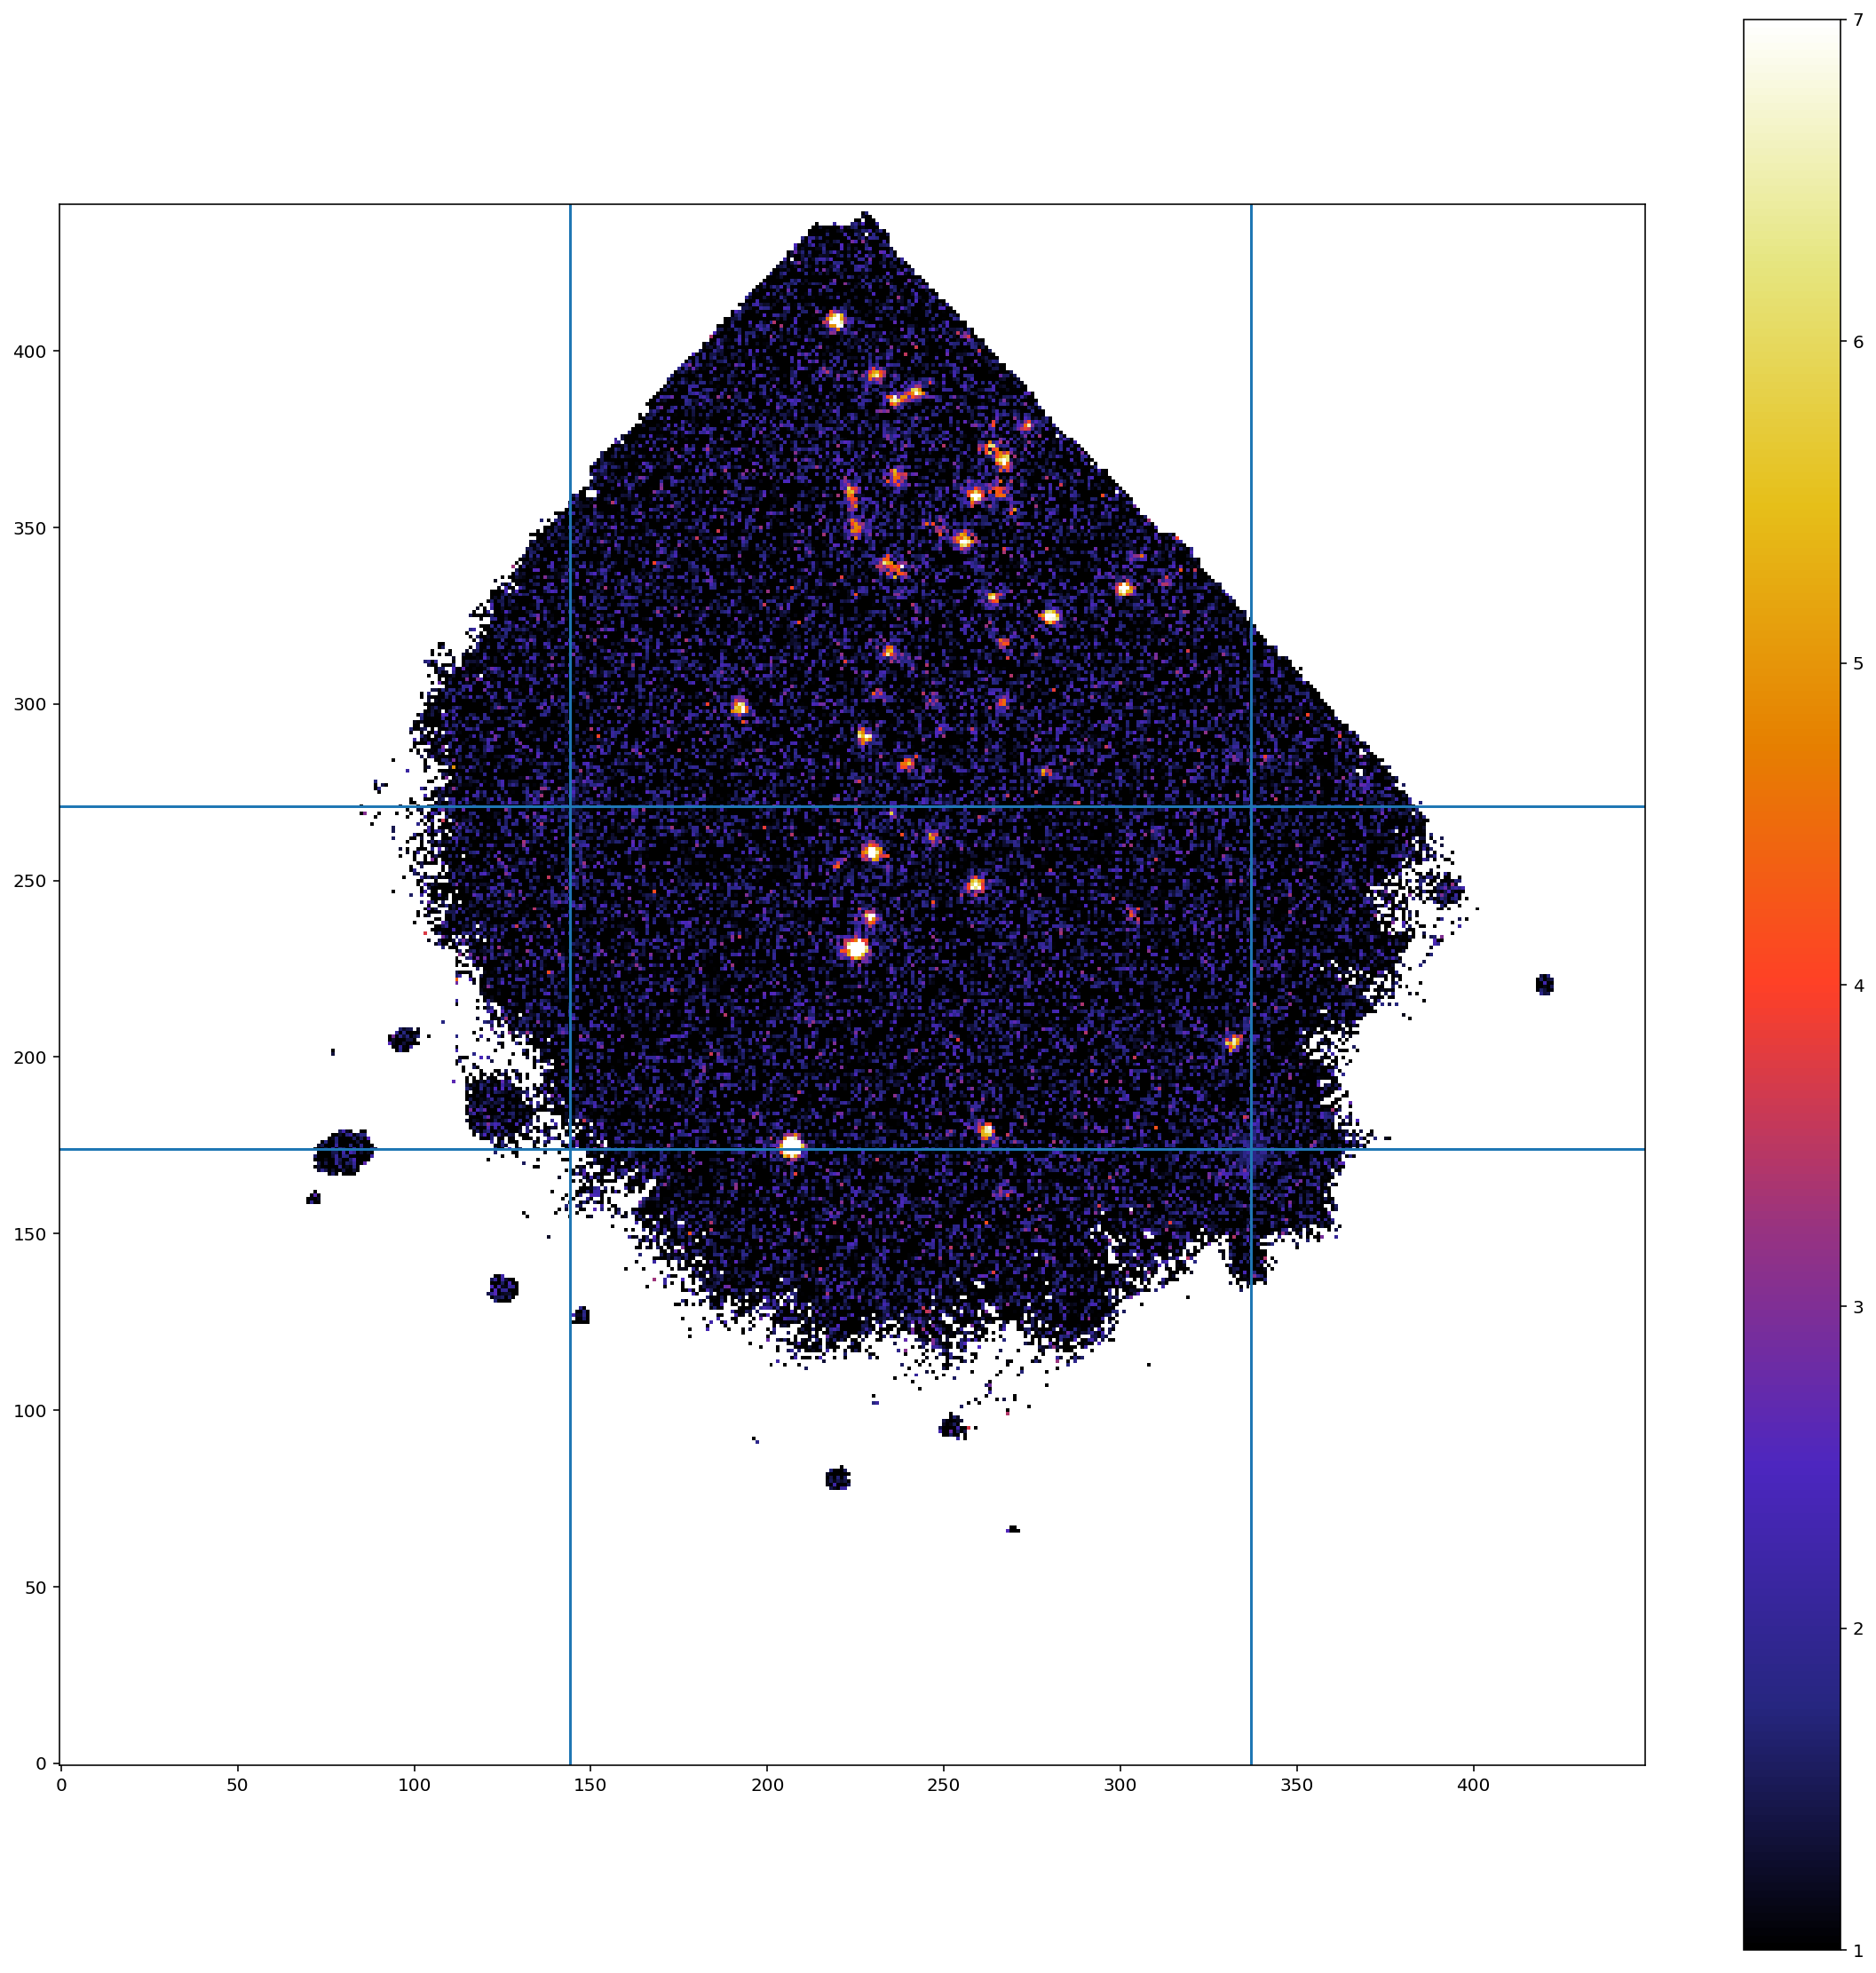

In [10]:
plt.figure(figsize=(20,20))
plt.imshow(A_rN_shape, origin="lower", cmap="CMRmap", vmin=1, vmax=7)
plt.colorbar()
n_pix = 20
plt.axhline(174)
plt.axvline(337)
star_0 = PNextractor(337, 174, n_pix, Gauss_F_shape )

plt.axhline(271)
plt.axvline(144)
star_1 = PNextractor(144, 271, n_pix, Gauss_F_shape)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 57
    # data points      = 400
    # variables        = 6
    chi-square         = 1209100.96
    reduced chi-square = 3068.78415
    Akaike info crit   = 3217.56923
    Bayesian info crit = 3241.51802
[[Variables]]
    moff_amp:  2522.97362 +/- 36.8060975 (1.46%) (init = 9000)
    x_0:       9.62918213 +/- 0.01885276 (0.20%) (init = 10)
    y_0:       10.3366135 +/- 0.01885286 (0.18%) (init = 10)
    FWHM:      3.83168945 +/- 0.05360340 (1.40%) (init = 6)
    beta:      3.16195595 +/- 0.33747258 (10.67%) (init = 6)
    bkg:       9.70082973 +/- 4.46528091 (46.03%) (init = 0.001)
[[Correlations]] (unreported correlations are < 0.100)
    C(moff_amp, FWHM) = -0.839
    C(FWHM, beta)     =  0.724
    C(beta, bkg)      =  0.670
    C(moff_amp, beta) = -0.621
    C(moff_amp, bkg)  = -0.362
    C(FWHM, bkg)      =  0.259
None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 89
    # dat

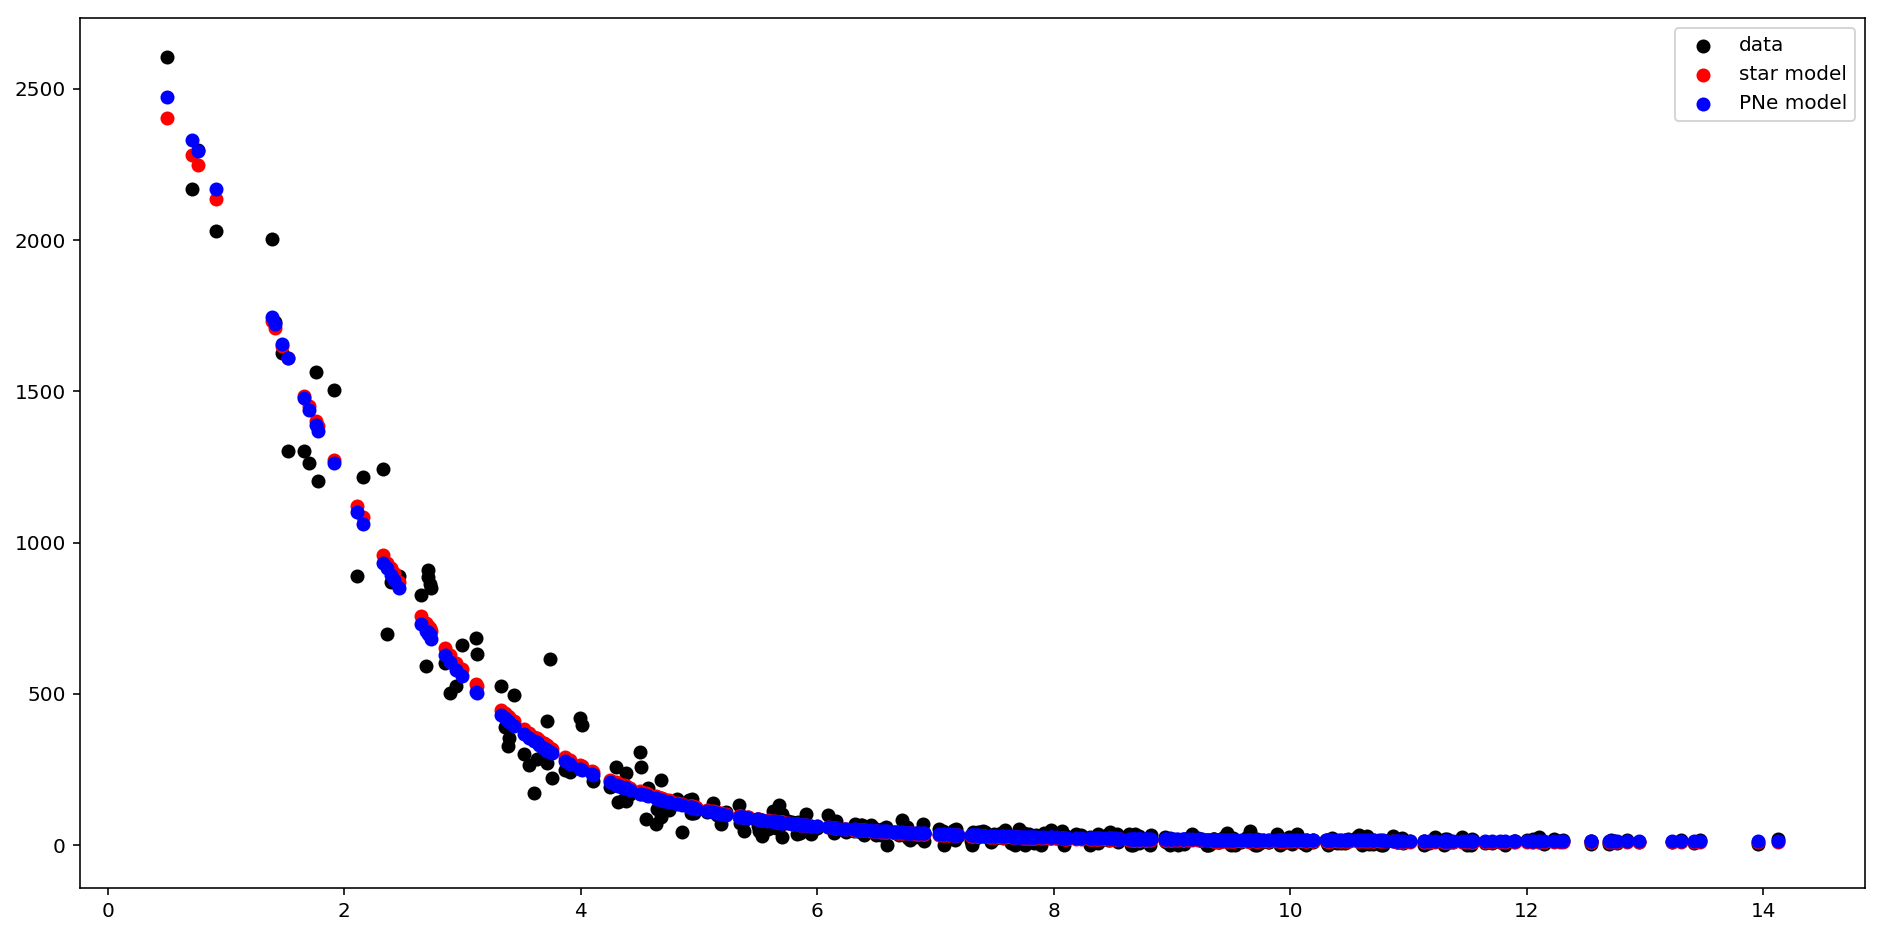

In [12]:
X_AOI, Y_AOI = np.mgrid[:n_pix,:n_pix]
star_ = star_0
coordinates = [(n,m) for n in range(n_pix) for m in range(n_pix)]

x_fit = np.array([item[0] for item in coordinates])
y_fit = np.array([item[1] for item in coordinates])

#list_of_residuals = np.zeros(len())
list_of_flux = []

def residuals(params, x_2D, y_2D, data):
    moff_amp = params["moff_amp"]
    x_0 = params["x_0"]
    y_0 = params["y_0"]
    FWHM = params["FWHM"]
    beta = params["beta"]
    bkg = params["bkg"]

    gamma = FWHM / (2. * np.sqrt(2.**(1./beta) - 1.))
    rr_gg = ((np.array(x_2D) - x_0)**2 + (np.array(y_2D) - y_0)**2) / gamma**2
    model = moff_amp * (1 + rr_gg)**(-beta) + bkg
    list_of_flux.clear()
    list_of_flux.append(model)
    #list_of_residuals[spec_num] = np.std(data - model)
    
    return data - model #/ np.std(flatten(data))

# Star initial parameters
S_params = Parameters()
S_params.add('moff_amp', value=9000., min=0.0001)
S_params.add('x_0', value=(n_pix/2), min=0001., max=n_pix)
S_params.add('y_0', value=(n_pix/2), min=0001., max=n_pix)
S_params.add('FWHM', value=6., min=0.001, max=30., vary=True)
S_params.add("beta", value=6., min=0.001, vary=True)
S_params.add("bkg", value=0.001, min=0.00001, max=10000, vary=True)

#list_of_std = [np.abs(np.std(spec)) for spec in flat_raw_data]
#input_errors = [np.repeat(list_of_std[i], len(wavelength)) for i in np.arange(0,len(list_of_std))]

S_results = minimize(residuals, S_params, args=(x_fit, y_fit, star_), nan_policy="propagate")
print(report_fit(S_results))
star_model = list_of_flux

# PNe initial Parameters
P_params = Parameters()
P_params.add('moff_amp', value=9000., min=0.0001)
P_params.add('x_0', value=(n_pix/2), min=0001., max=n_pix)
P_params.add('y_0', value=(n_pix/2), min=0001., max=n_pix)
P_params.add('FWHM', value=3.7, min=0.001, max=12., vary=False)
P_params.add("beta", value=3.01, min=0.001, max=12., vary=False)
P_params.add("bkg", value=0.01, min=0.00001, max=10000, vary=True)
#S_results.params["bkg"].value
#FWHM:  4.08291829123 0.106292926432
#Beta:  2.12207462875 0.195897897074


P_results = minimize(residuals, P_params, args=(x_fit, y_fit, star_), nan_policy="propagate")
print(report_fit(P_results))
PNe_model = list_of_flux

PNe_residuals = residuals(P_results.params, x_fit, y_fit, star_)
PNe_model = star_ - PNe_residuals

star_residuals = residuals(S_results.params, x_fit, y_fit, star_)
star_model = star_ - star_residuals

rad= np.sqrt((x_fit - S_results.params["x_0"])**2 + (y_fit - S_results.params["y_0"])**2)
plt.figure(figsize=(16,8))
plt.scatter(rad, star_, color="k", label="data")
plt.scatter(rad, star_model, color="r", label="star model")
plt.scatter(rad, PNe_model, color="blue", label="PNe model")
plt.legend()

In [14]:
print("Star_1: ", np.sum(star_))
print("Star: ", np.sum(star_model))
print("PNe:  ", np.sum(PNe_model))
print("Diff: ", np.abs(np.sum(star_model)-np.sum(PNe_model)))

Star_1:  58301.14403692686
Star:  58301.14666412129
PNe:   58301.14402787345
Diff:  0.002636247838381678


In [14]:
temp_g_A = gauss_A_shape
temp_g_A[gauss_A_shape==gauss_A_shape[0,0]] = np.nan

In [4]:
temp_A_rN = A_rN_shape
temp_A_rN[A_rN_shape==A_rN_shape[0,0]] = np.nan

31


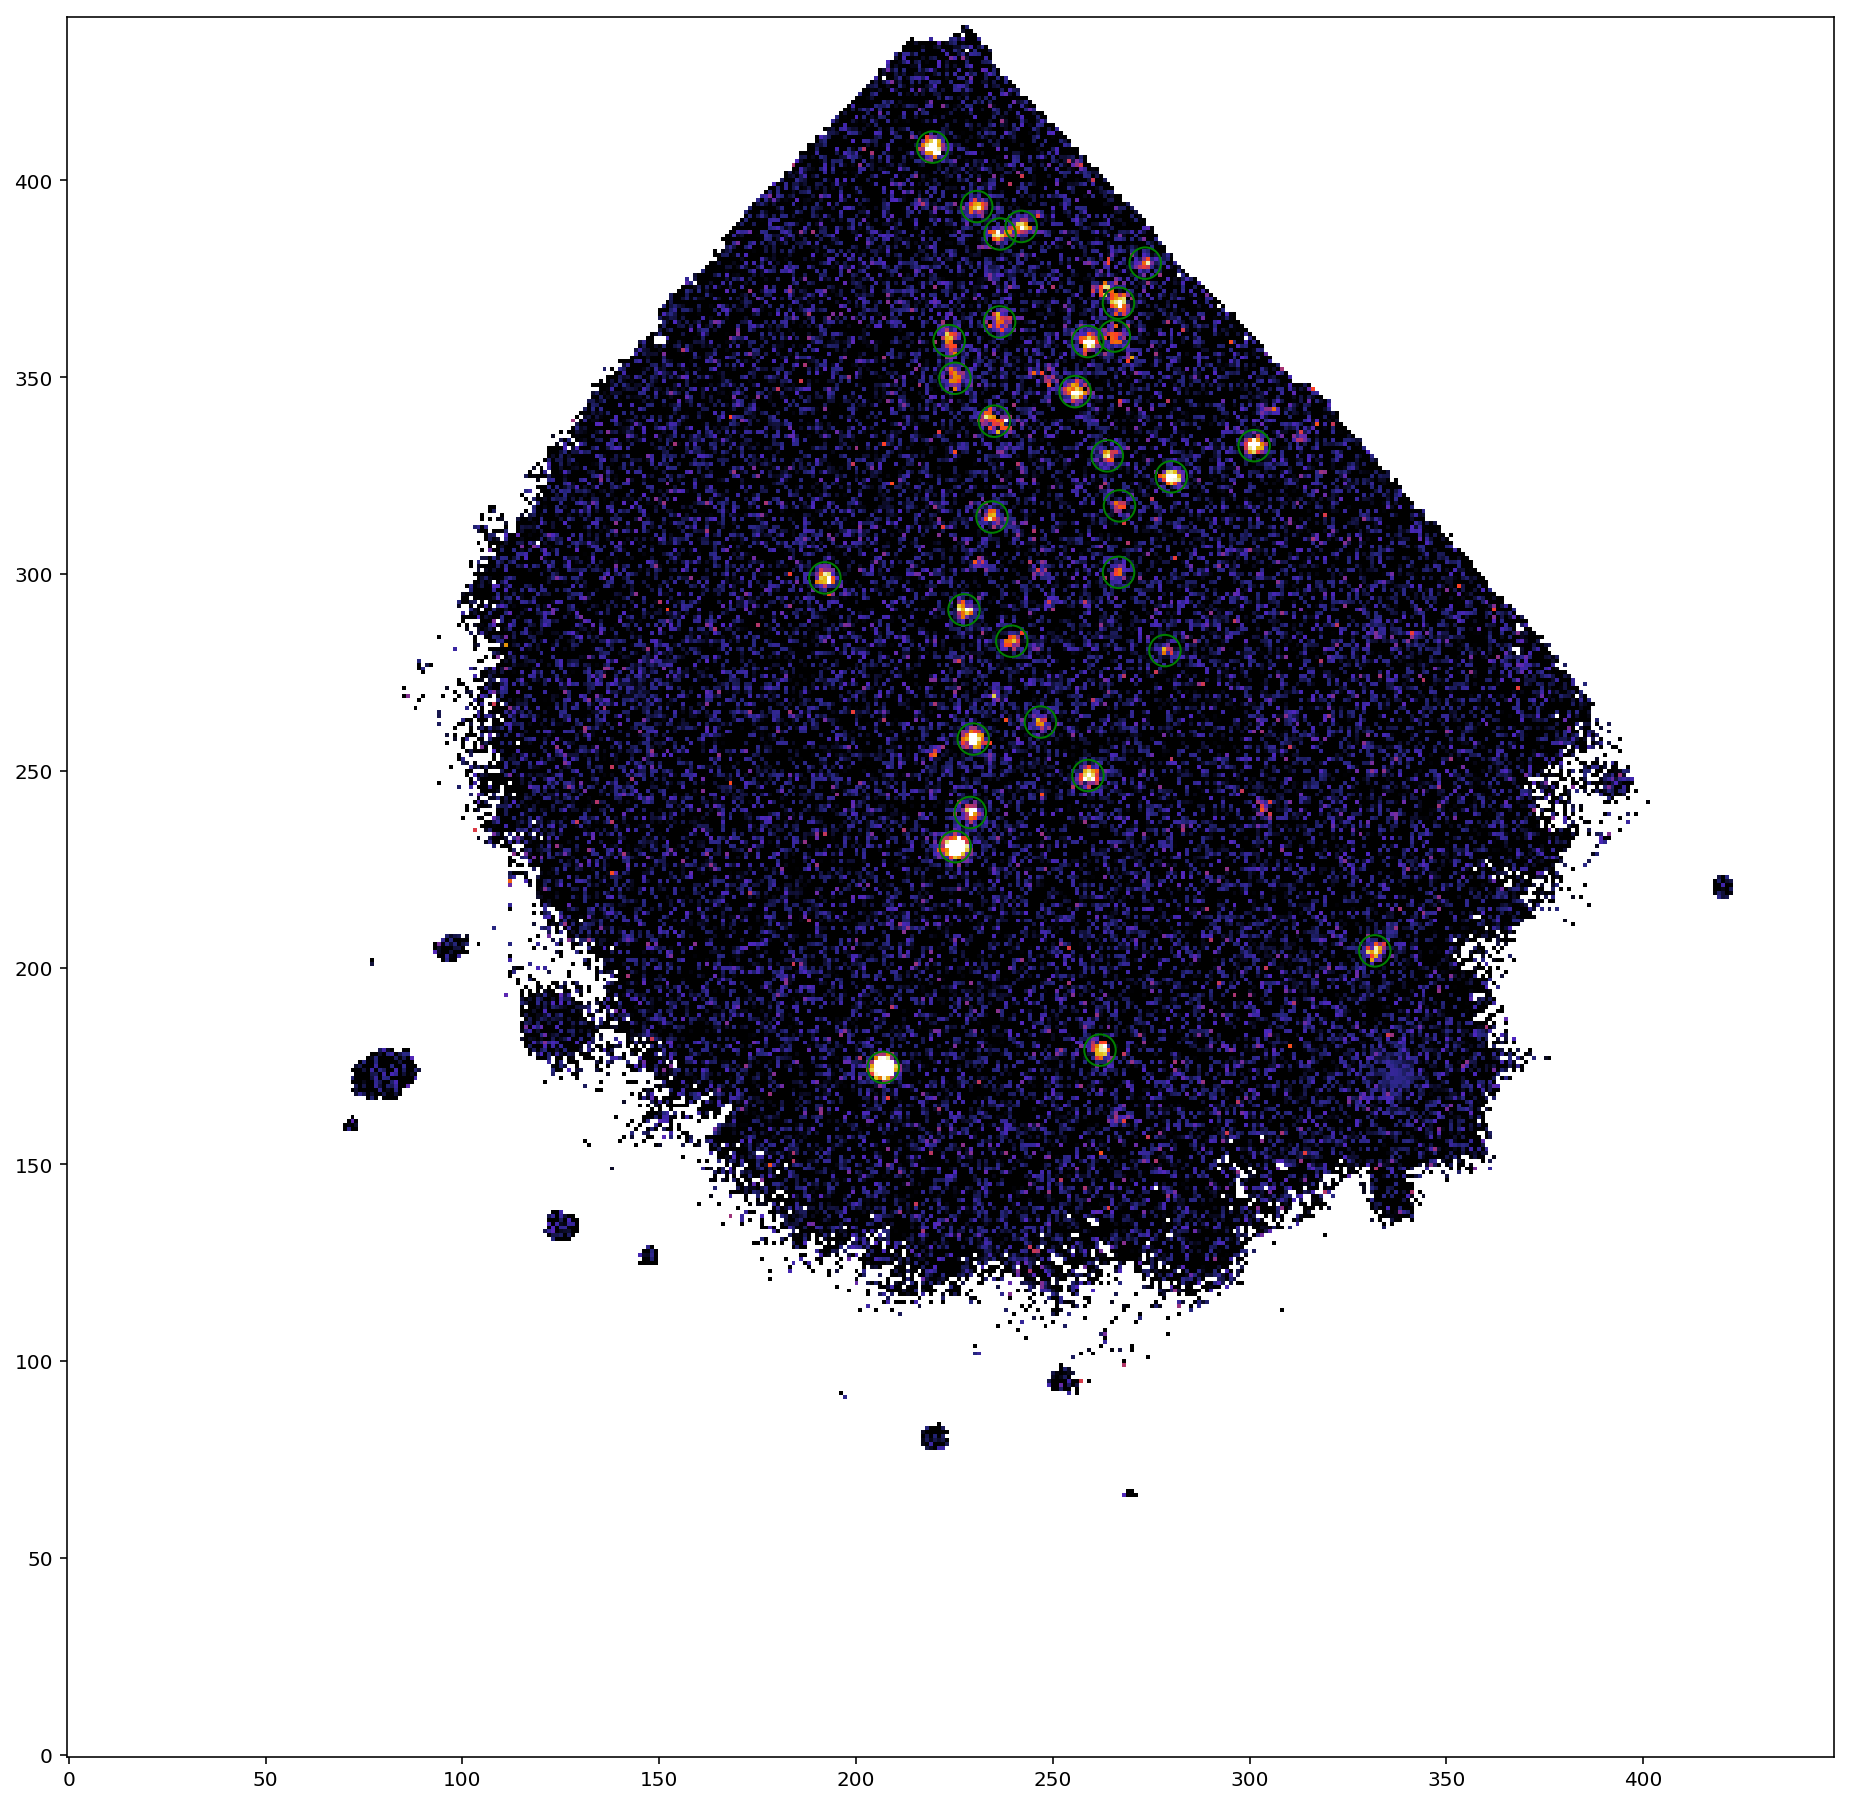

In [5]:
import sep
from photutils import CircularAperture

Y, X = np.mgrid[:y_data, :x_data]
xe = 236
ye = 197
length= 140
width = 60

alpha = 0.2
elip_mask_gal = (((X-xe) * np.cos(alpha) + (Y-ye) * np.sin(alpha)) / (width/2)) ** 2 + (((X-xe) * np.sin(alpha) - (Y-ye) * np.cos(alpha)) / (length/2)) ** 2 <= 1
#galaxy_elip_mask = np.load("exported_data/FCC167/mask.npy")
#objects = sep.extract(gauss_A.reshape(441, 444), 7., err=list_of_std.reshape(y_data, x_data), clean=False, mask=elip_mask)
objects = sep.extract(A_rN_shape, 2.5, clean=True)#, mask=elip_mask_gal+PNe_17_mask)
x_sep = objects["x"]
y_sep = objects["y"]

positions = (x_sep, y_sep)
apertures = CircularAperture(positions, r=4)
plt.figure(figsize=(16,16))
plt.imshow(A_rN_shape, origin="lower", cmap="CMRmap", vmin=1, vmax=7.)
apertures.plot(color="green")

#ax = plt.gca()
#elip_gal = Ellipse((xe, ye), width, length, angle=alpha*(180/np.pi), fill=False, color="white")
#PNe_17 = Circle((213,142), fill=False, color="white")
#elip_extra = Ellipse((210,230), 20, 50, angle=alpha*(180/np.pi), fill=False, color="white")

#ax.add_artist(elip_gal)
#ax.add_artist(PNe_17)

#ax.add_artist(circ)

x_sep[26] = x_sep[26]-1
sep_x_y_list = [[x,y] for x,y in zip(x_sep, y_sep)]


print(len(x_sep))
np.save("exported_data/FCC255/sep_x_y_list", sep_x_y_list)

In [7]:
sep_x_y_list[17]

[213.2349348499924, 141.79987220380266]

In [25]:
temp_A_rN = A_rN_shape
temp_A_rN[temp_A_rN==True]=np.nan

In [26]:

mask = A_rN_shape == A_rN_shape[0,0]

X, Y = np.mgrid[:y_data, :x_data]

#alpha = 0.17
#elip_mask = (((Y-234) * np.cos(alpha) + (X-205) * np.sin(alpha)) / 22.5) ** 2 + (((Y-234) * np.sin(alpha) - (X-205) * np.cos(alpha)) / 60) ** 2 <= 1
mask = mask +  elip_mask

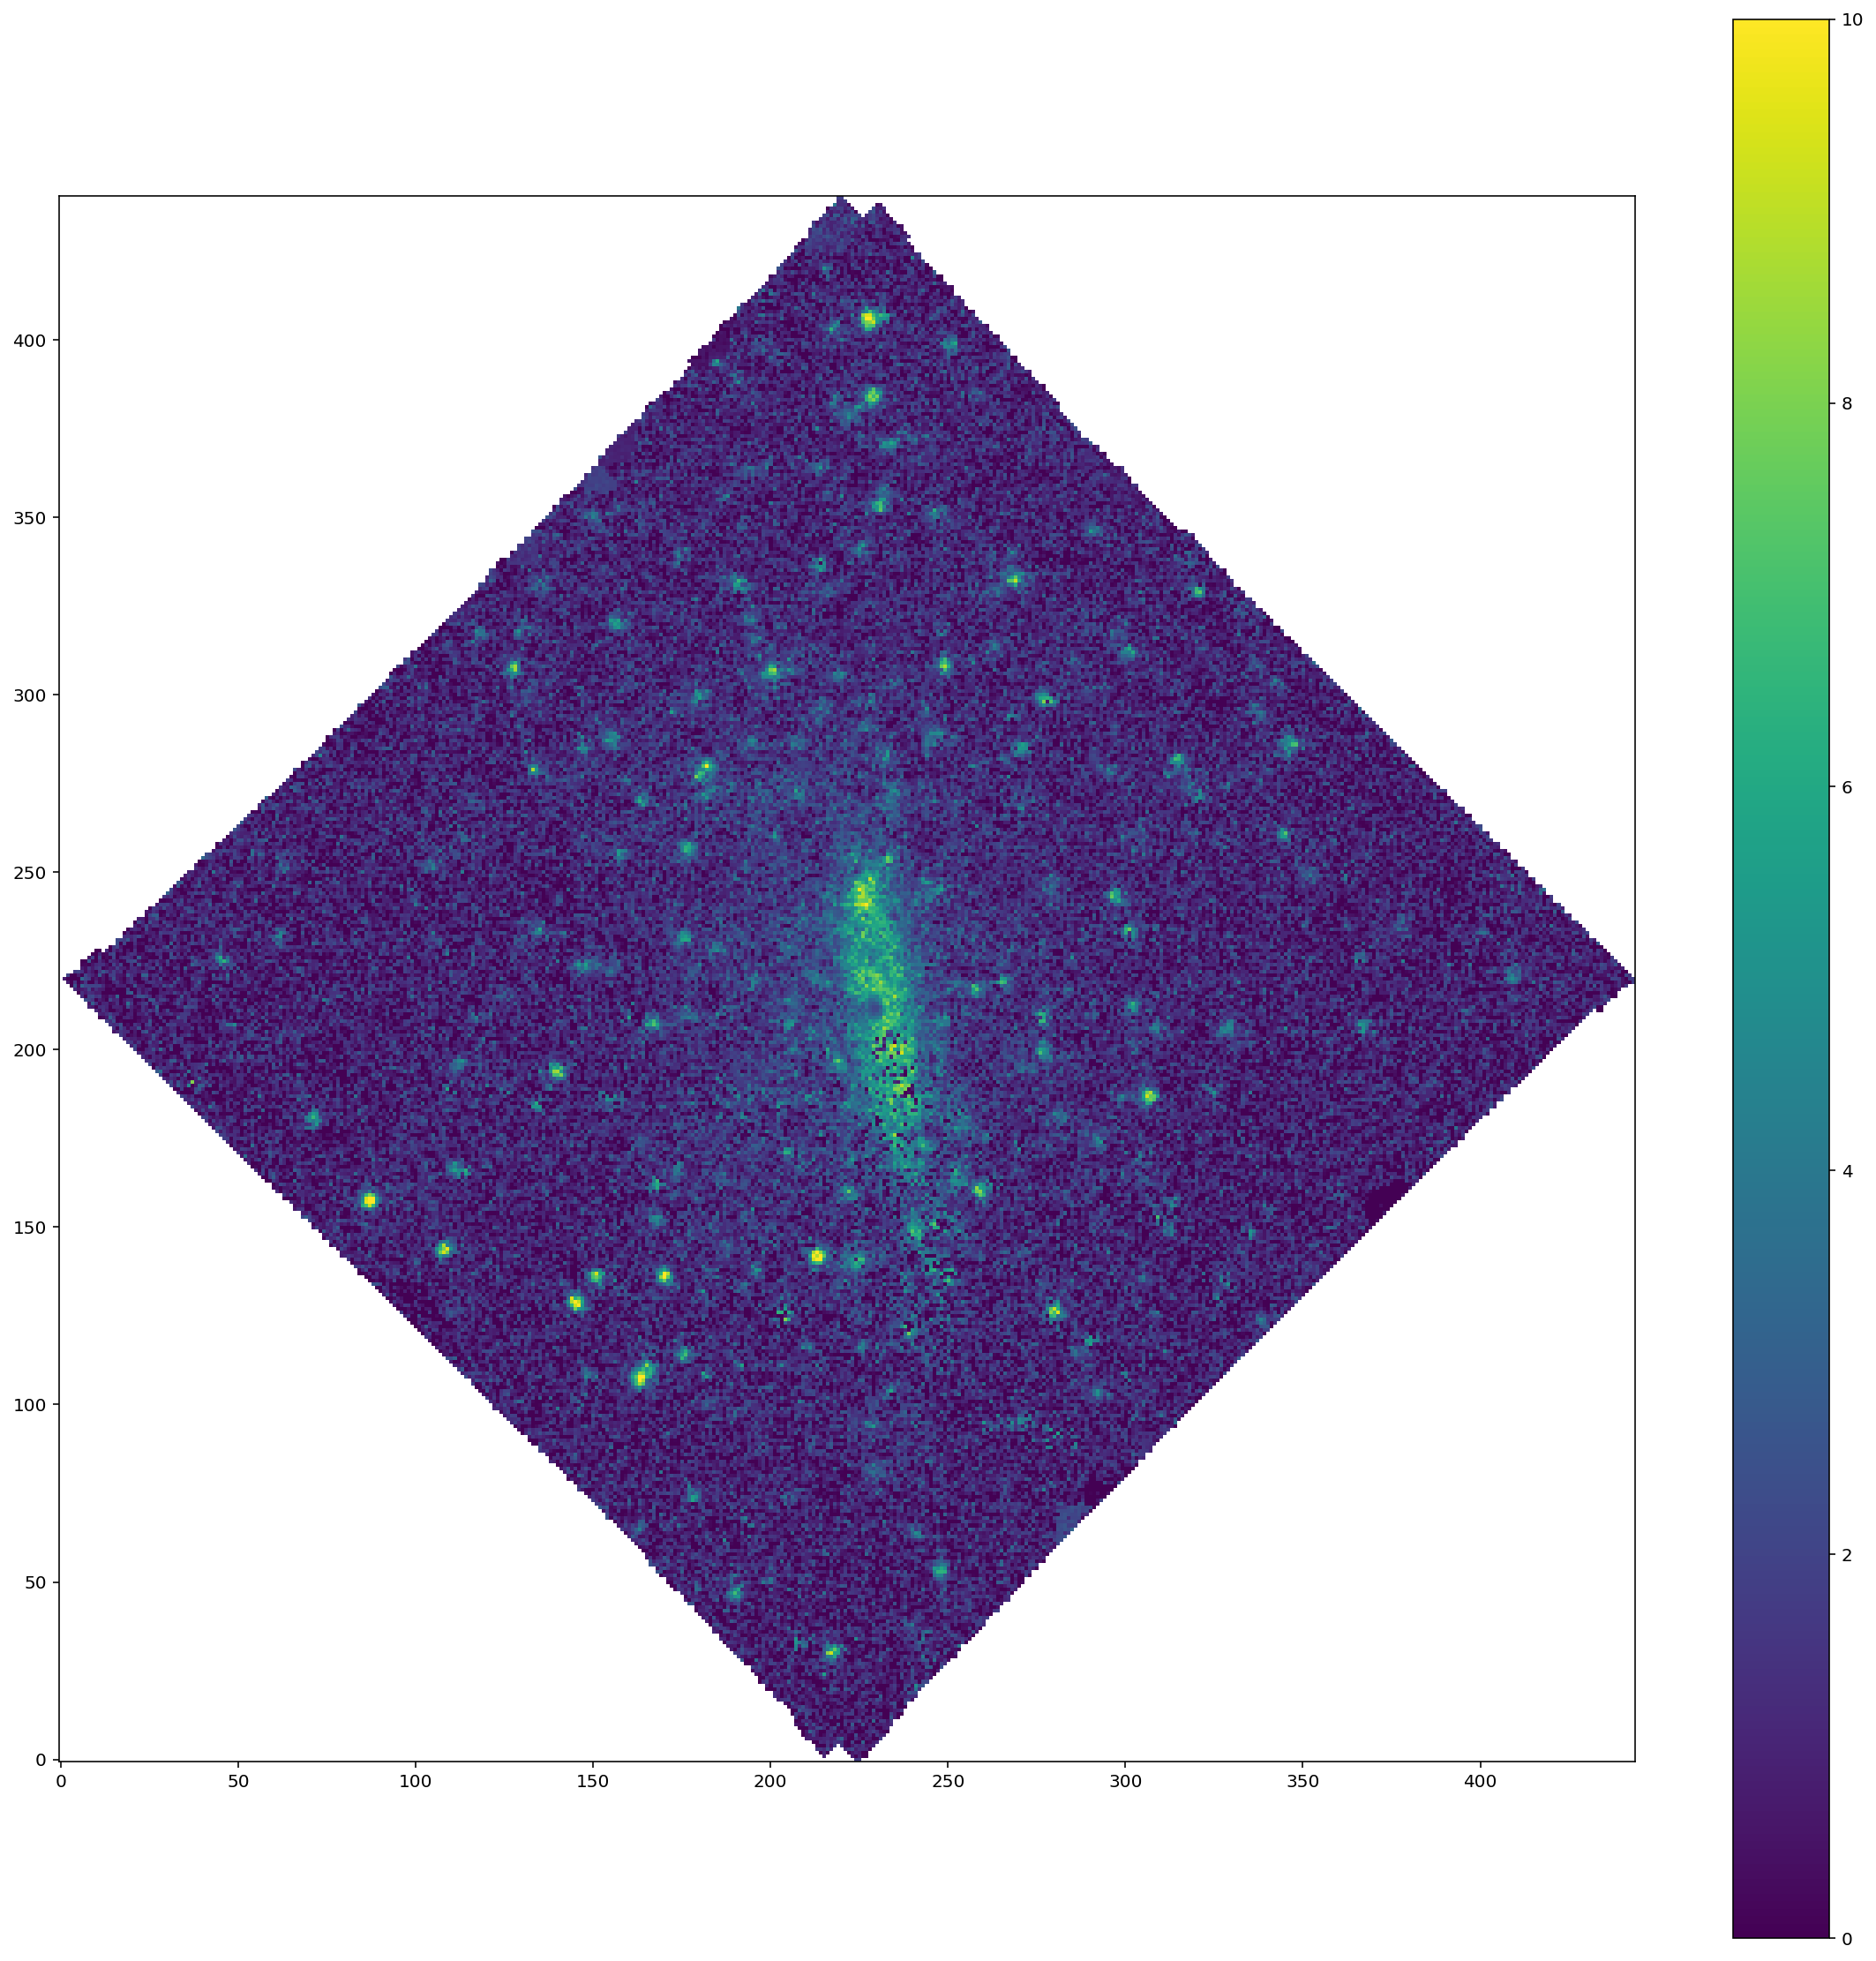

In [29]:
plt.figure(figsize=(20,20))
plt.imshow(temp_A_rN, origin="lower", vmin=0., vmax=10.)
plt.colorbar()

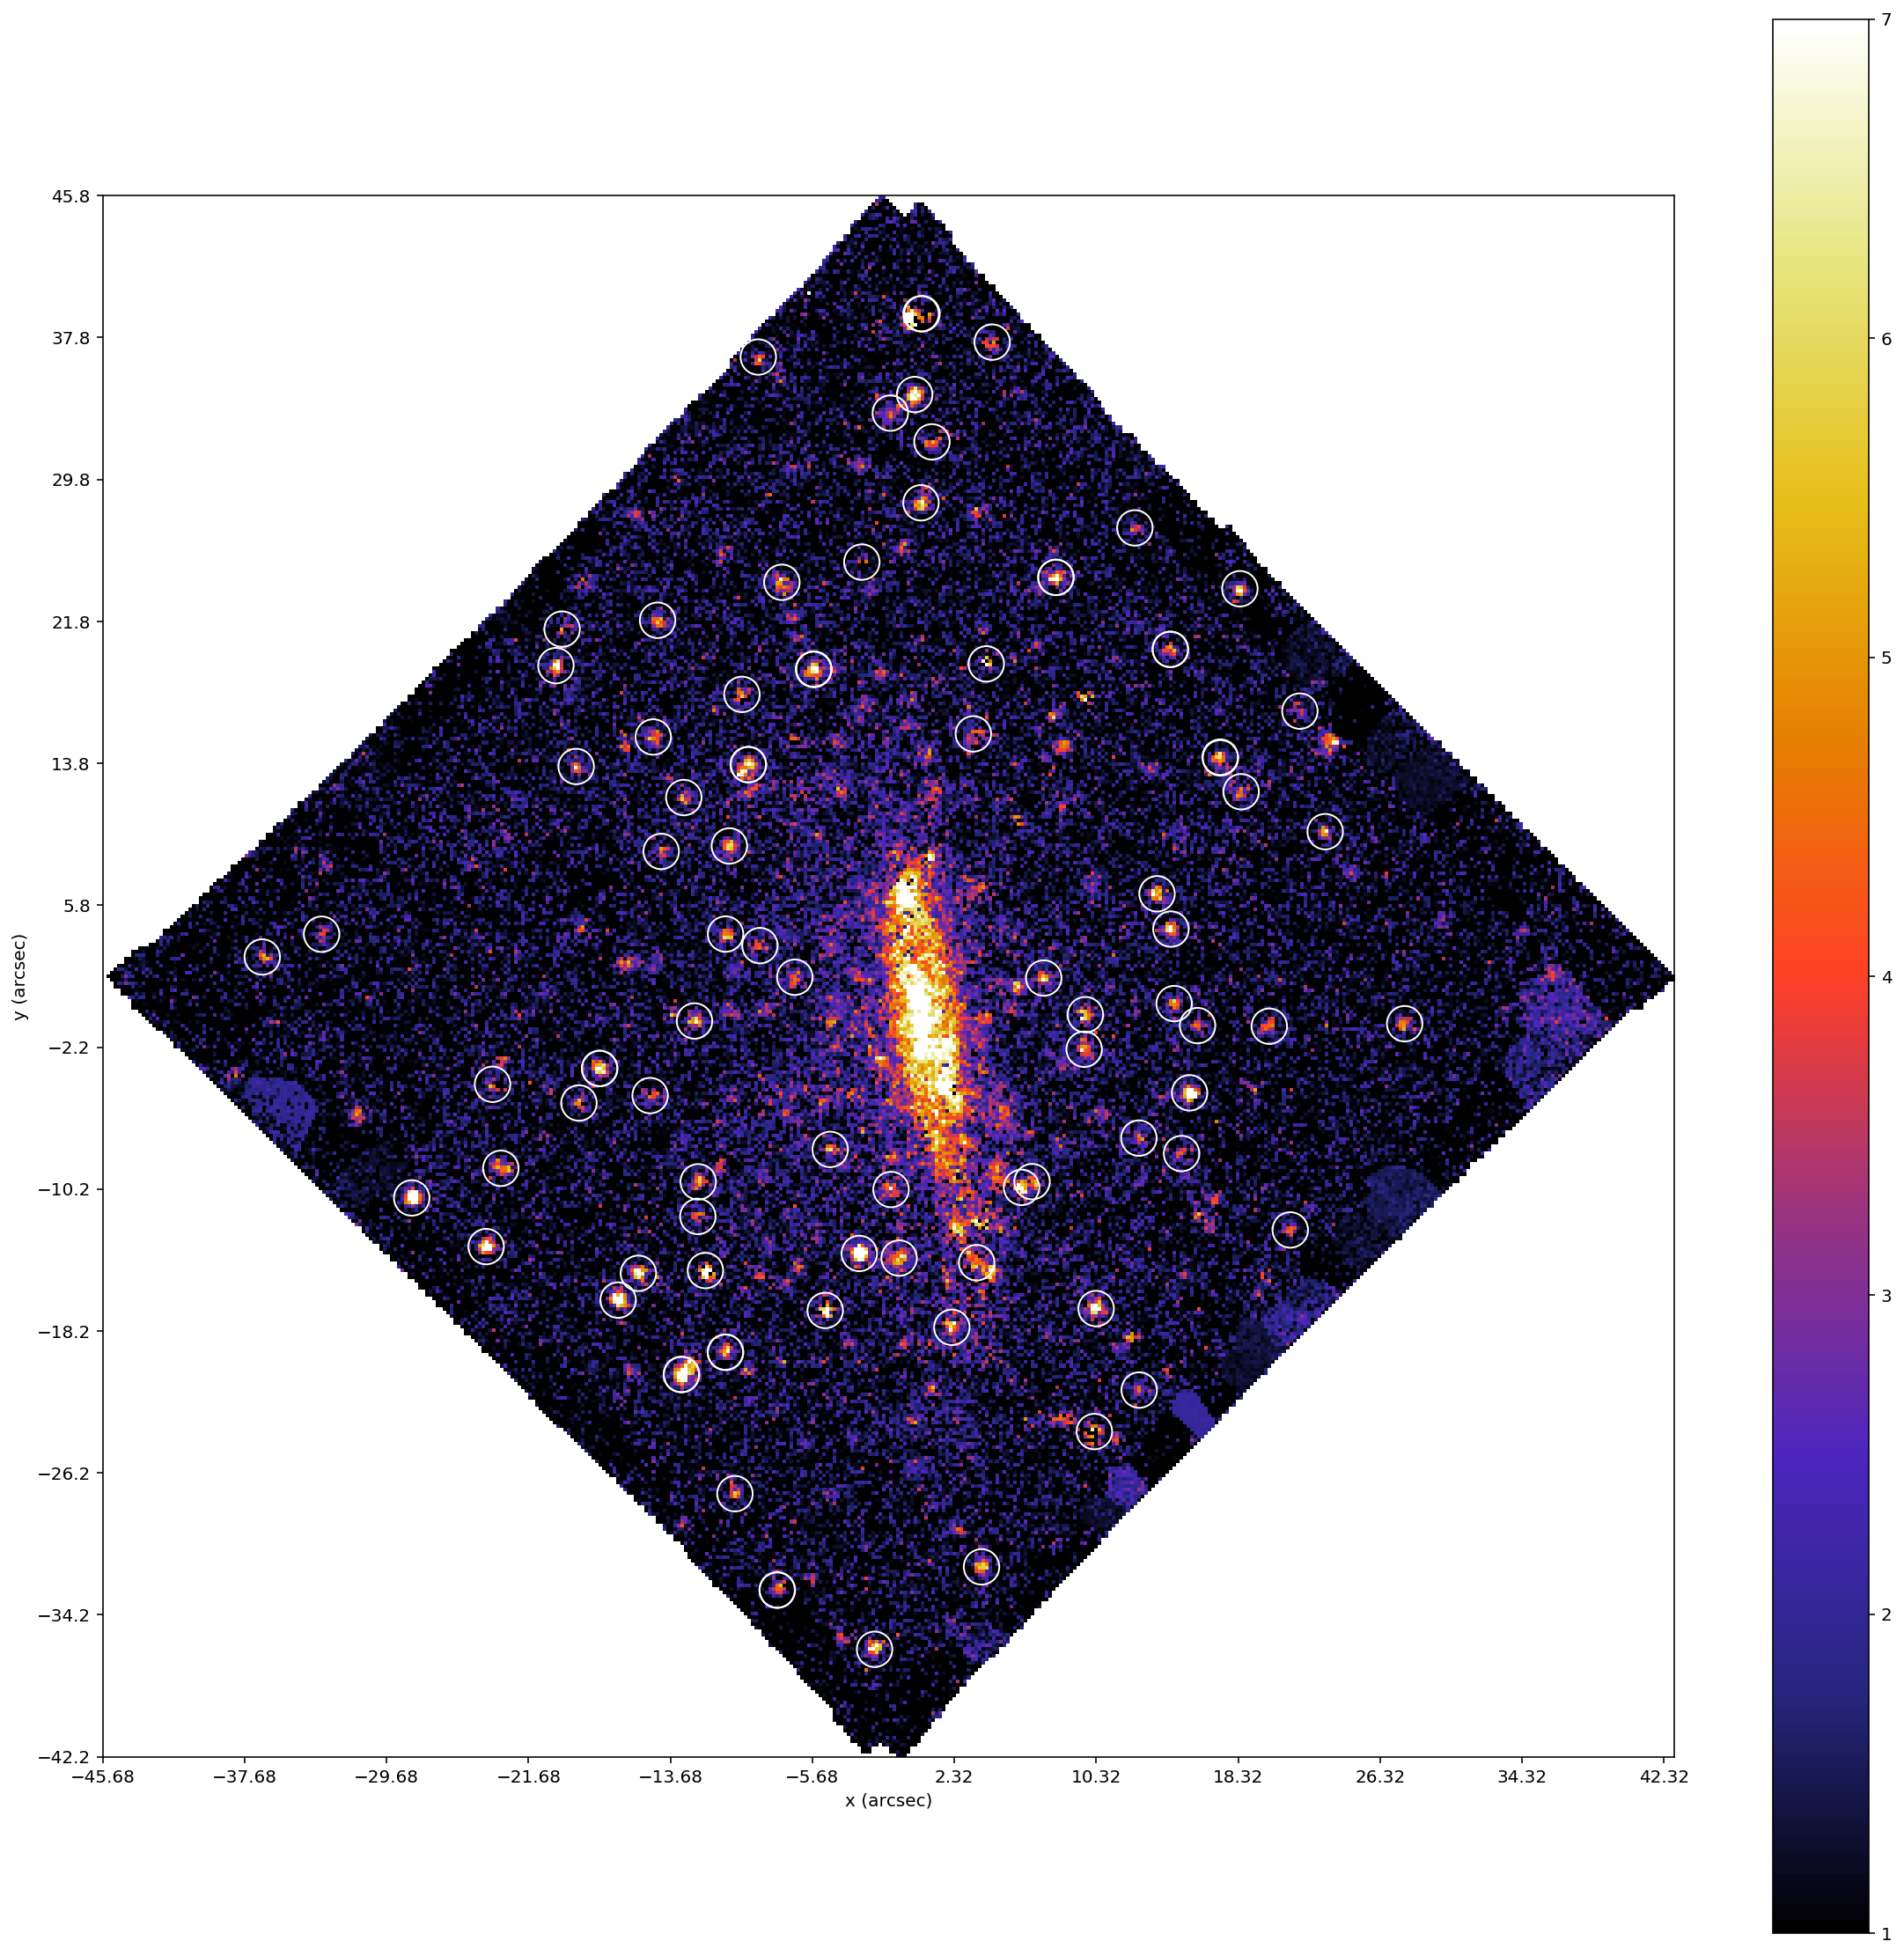

In [9]:
coords = ascii.read("FCC167_data/FCC167_xy_PNe_Marc_forThomas.txt", names=["x_PNe", "y_PNe"])
x_PNe = coords["x_PNe"]
y_PNe = coords["y_PNe"]
x_y_list = [x_PNe, y_PNe]

coords_arc = ascii.read("FCC167_data/FCC167_xy_forThomas.txt", names=["x","y"])
x_arc = coords_arc["x"][:444]
y_arc = coords_arc["y"][::444]

plt.figure(3,figsize=(20,20))
plt.imshow(A_rN_shape, extent = (x_arc[0], x_arc[-1], y_arc[0],y_arc[-1]), origin="lower", cmap="CMRmap", vmin=1, vmax=7)
plt.xticks(x_arc[::40])
plt.yticks(y_arc[::40])
cb = plt.colorbar()
plt.xlabel("x (arcsec)")
plt.ylabel("y (arcsec)")

for x, y in zip(x_PNe,y_PNe):
    ax = plt.gca()
    circ = plt.Circle((x,y),1, color="white", fill=False)
    ax.add_artist(circ)
    plt.draw()
    
plt.savefig("Plots/FCC167_circled points.png")
#for i, item in enumerate(x_y_list):
#    ax = plt.gca()
#    circ = plt.Circle((item[0],item[1]),6, color="white", fill=False)
#    ax.add_artist(circ)
#    ax.annotate(i+1, (item[0]-8, item[1]-16), color="white", size=25)
#   plt.draw()